<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/PythonProgramming/CTB3311_CMIPinPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# CMIP processing in python
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl |  [@steflhermitte](https://twitter.com/StefLhermitte) | [www.earthmapps.io](http://www.earthmapps.io))*

*with inspiration and fragments from:*

 * [Ryan Abernathey](https://twitter.com/rabernat)'s [CMIP6 in the Cloud Five Ways](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396)
 * [Xarray documentation](https://xarray.pydata.org/en/stable/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zxSHdTAubGlO6xQpeVtsP2iFb2JjlE25?usp=sharing) 
[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)





## Introduction

There is a variety of ways to visualize and process CMIP data with a set of tools that already can do much of the work for you:

| Tool                                                                             	| Reanalysis 	| CMIP5                   	| CMIP6                  	| Cordex 	| Area averaged  time series 	| Maps 	| Post-processing 	|
|----------------------------------------------------------------------------------	|------------	|-------------------------	|------------------------	|--------	|----------------------------	|------	|-----------------	|
| [Climate explorer](https://climexp.knmi.nl/)                                     	| +          	| ~30 vars + ~30 extremes 	| 5 vars; no extremes    	| 4 vars 	| +                          	| +    	| +               	|
| [Climate atlas](https://climexp.knmi.nl/plot_atlas_form.py)                      	| +          	| ~10 vars + ~25 extremes 	| -                      	| 4 vars 	| +                          	| +    	| +               	|
| [Unimelb's CMIP viewer](https://cmip6.science.unimelb.edu.au/search)             	| -          	| ~ 40 vars; no extremes  	| ~ 40 vars; no extremes 	| -      	| ++                         	| -    	| -               	|
| [Climate renanalyzer](https://climatereanalyzer.org/reanalysis/monthly_tseries/) 	| +          	| 3 vars; no extremes     	| -                      	| -      	| +                          	| -    	| -               	|

Each of this tool relies on subsets of variables or precalculated averages and therefore does not allow full control. Therefore, we are going to focus in this notebook to get the raw CMIP output directly. There are multiple ways to do this, but in this notebook we are going to use Google's colab. For approaches, please check this nice overview of [Ryan Abernathey : CMIP6 in the Cloud Five Ways](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396). Realize that processing in colab might not be ideal and a cloud based approach using a cluster like on [Pangeo](https://pangeo.io/) might be preferred, but this is beyond the scope of this course. If you are interested I recommend the TUDelft [MSc course on Big Data and Remote Sensing](https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=56333).



## Package installation in colab

Before we start, we need to install some additional packages in colab: 

In [1]:
# Install xarray, zarr etc
!pip install --upgrade xarray zarr gcsfs cftime nc-time-axis

Requirement already up-to-date: xarray in /usr/local/lib/python3.7/dist-packages (0.17.0)
Requirement already up-to-date: zarr in /usr/local/lib/python3.7/dist-packages (2.8.1)
Requirement already up-to-date: gcsfs in /usr/local/lib/python3.7/dist-packages (2021.4.0)
Requirement already up-to-date: cftime in /usr/local/lib/python3.7/dist-packages (1.4.1)
Requirement already up-to-date: nc-time-axis in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [2]:
# Install cartopy for maps
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip uninstall -y shapely # cartopy and shapely aren't friends (early 2020) 
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Cloning https://github.com/SciTools/cartopy.git to /tmp/pip-req-build-nryfjjep
  Running command git clone -q https://github.com/SciTools/cartopy.git /tmp/pip-req-build-nryfjjep
  Installing buil

In [3]:
# Install intake
!pip install --upgrade intake-esm
# For some strange reason you have to try install the package twice to avoid a later error
# when running .open_esm_datastore()
# !pip install --upgrade intake-esm

Requirement already up-to-date: intake-esm in /usr/local/lib/python3.7/dist-packages (2021.1.15)


Subsequently, we can load them and specify some output settings:

In [6]:
# Load packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xarray.plot
import zarr
import gcsfs
import intake
import cartopy.crs as ccrs
from tqdm import tqdm  

# Define output settings
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

## Browse and search data catalog

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6). Therefore it first reads [`pangeo-cmip6.json`](https://storage.googleapis.com/cmip6/pangeo-cmip6.json) file from the google cloud storage. This json-file contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, each line in the loaded file contains:
* a variable (`variable_id`), as a function of latitude, longitude, and time
* in an individual climate model experiment (`source_id`)
* developed by a specific institute (`institution_id`) 
* *forced* for a specific forcing experiment (`experiment_id`). 
* as part of the activity (`activity_id`). Activities are spin-offs of the overall CMIP activity that focuses specifically on different experiments. 

You can find an overview of the different settings and their parameters in this [gDoc](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit). In the following block we are going to load that metadata. Sometimes you need to run the cell twice to bypass an error.

In [7]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

Based on the previous output, you can see that this collection contains the simulated data from 494659 individual experiments, representing 86 different models from 36 different scientific institutions. There are 709 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 168 different forcing experiments.

If you look at the contents of this dataframe you see the metadata structure where the columns correspond to the CMI6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q) and the lecture slides.  

In [8]:
col.df

activity_id institution_id  ... dcpp_init_year   version
0       HighResMIP           CMCC  ...            NaN  20170706
1       HighResMIP           CMCC  ...            NaN  20170706
2       HighResMIP           CMCC  ...            NaN  20170706
3       HighResMIP           CMCC  ...            NaN  20170706
4       HighResMIP           CMCC  ...            NaN  20170706
...            ...            ...  ...            ...       ...
494654        CMIP        AS-RCEC  ...            NaN  20210416
494655        CMIP        AS-RCEC  ...            NaN  20210416
494656        CMIP        AS-RCEC  ...            NaN  20210416
494657        CMIP        AS-RCEC  ...            NaN  20210416
494658        CMIP        AS-RCEC  ...            NaN  20210416

[494659 rows x 11 columns]

Subsequently, we can use the search function to search and subset the data. Here we filter the data to find monthly (`Amon`) surface air temperature (`tas`) for historical experiments (`historical`) from the CMIP activity (`CMIP`) resulting in 53 models with output.

In [10]:
experiment = 'historical' # pick the `historical` forcing experiment
var = 'tas'               # choose to look at near-surface air temperature (tas) as our variable
table = 'Amon'            # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
member = 'r1i1p1f1'       # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

col_subset = col.search(experiment_id= experiment,  
                 table_id=table,             
                 variable_id=var,           
                 member_id = member)     
col_subset.df 

activity_id       institution_id  ... dcpp_init_year   version
0         CMIP            NOAA-GFDL  ...            NaN  20180701
1         CMIP                 IPSL  ...            NaN  20180803
2         CMIP            NASA-GISS  ...            NaN  20180827
3         CMIP                  BCC  ...            NaN  20181126
4         CMIP                MIROC  ...            NaN  20181212
5         CMIP                  BCC  ...            NaN  20181214
6         CMIP                  MRI  ...            NaN  20190222
7         CMIP                 NCAR  ...            NaN  20190227
8         CMIP                 NCAR  ...            NaN  20190308
9         CMIP                  SNU  ...            NaN  20190323
10        CMIP            NASA-GISS  ...            NaN  20190403
11        CMIP                CCCma  ...            NaN  20190429
12        CMIP                  INM  ...            NaN  20190530
13        CMIP                  INM  ...            NaN  20190610
14        CMIP    HAMMOZ-Consortium  ...            NaN  20190627
15        CMIP                NUIST  ...            NaN  20190630
16        CMIP                 CAMS  ...            NaN  20190708
17        CMIP                MPI-M  ...            NaN  20190710
18        CMIP                MPI-M  ...            NaN  20190710
19        CMIP            NOAA-GFDL  ...            NaN  20190726
20        CMIP                   UA  ...            NaN  20190731
21        CMIP            NASA-GISS  ...            NaN  20190815
22        CMIP                  NCC  ...            NaN  20190815
23        CMIP                  CAS  ...            NaN  20190818
24        CMIP         E3SM-Project  ...            NaN  20190913
25        CMIP                  CAS  ...            NaN  20190927
26        CMIP             NIMS-KMA  ...            NaN  20191028
27        CMIP                KIOST  ...            NaN  20191106
28        CMIP         CSIRO-ARCCSS  ...            NaN  20191108
29        CMIP                  NCC  ...            NaN  20191108
30        CMIP             FIO-QLNM  ...            NaN  20191115
31        CMIP                CSIRO  ...            NaN  20191115
32        CMIP                 NCAR  ...            NaN  20191120
33        CMIP                 NCAR  ...            NaN  20191120
34        CMIP         E3SM-Project  ...            NaN  20191211
35        CMIP            CCCR-IITM  ...            NaN  20191226
36        CMIP                  AWI  ...            NaN  20200212
37        CMIP  EC-Earth-Consortium  ...            NaN  20200217
38        CMIP  EC-Earth-Consortium  ...            NaN  20200225
39        CMIP                  CAS  ...            NaN  20200302
40        CMIP  EC-Earth-Consortium  ...            NaN  20200310
41        CMIP                  THU  ...            NaN  20200417
42        CMIP                 CMCC  ...            NaN  20200616
43        CMIP              AS-RCEC  ...            NaN  20200623
44        CMIP         E3SM-Project  ...            NaN  20200623
45        CMIP  EC-Earth-Consortium  ...            NaN  20200624
46        CMIP                  AWI  ...            NaN  20200720
47        CMIP                  NCC  ...            NaN  20200724
48        CMIP                 IPSL  ...            NaN  20200729
49        CMIP                 CMCC  ...            NaN  20200904
50        CMIP  EC-Earth-Consortium  ...            NaN  20210113
51        CMIP                 CMCC  ...            NaN  20210114
52        CMIP                 IPSL  ...            NaN  20210216

[53 rows x 11 columns]

## Load Data into xarray

Now that we have subsetted the data based on their climate model experiment description we can load them into xarray data structures. Xarray is a python data structure (similar to for example numpy) designed to work with labelled multi-dimensional arrays. It is often used in the climate community as it is tailored to working with netCDF files, which is the most common climate data format. Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

In [11]:
# convert data catalog into a dictionary of xarray datasets
ds_dict = col_subset.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
# list the keys of our dictionary. This shows the name of all our 53 models
list(ds_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn',
 'CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn',
 'CMIP.CAS.FGOALS-g3.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn',
 'CMIP.FIO-QLNM.FIO-ESM-2-0.historical.Amon.gn',
 'CMIP.NCC.NorESM2-LM.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.Amon.gr',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr',
 'CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn',
 'CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn',
 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.Amon.gn',
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn',
 'CMIP.KIOST.KIOST-ESM.historical.Amon.gr1',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amo

Subsequently, we can read one model (e.g. `ds = ds_dict[key]`) by just subsetting based on the key/name.

In [13]:
ds = ds_dict['CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.Amon.gr']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 256, lon: 512, member_id: 1, time: 1980)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(512, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 126, 256, 512), meta=np.ndarray>
Attributes: (12/51)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.5.0
    ...                      ...
    variable_id:             tas
    variant_info:            forcing: Nat.Ant. Member generated from autosubm...
    variant_label:           r1i1p1f1
    version_id:              v20210113
    intake_esm_varname:      ['tas']
    intake_esm_dataset_key:  CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical...

When looking at the output, you can see that the `tas` variable has four dimensions `member,time,lat,lon`, where we have 256x512 lat/lon grid for one member and 1980 time steps (i.e. months). Moreover there is a `nband` dimension that stores the lat/lon boundaries of each grid cell (e.g., if we have a 1 degree model than lat/lon will contain values at 0.5 degrees, whereas lat_bnds/lon_bnds will contain 2 dimensions at the boundaries 0-1). We can however neglect `bnds` dimension or even drop it from the data set.

In [14]:
# Drop all coordinates not in ['lat','lon','time']
for coord in ds.coords:
    if coord not in ['lat','lon','time']:
      ds = ds.drop(coord)
ds

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member_id: 1, time: 1980)
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: member_id
Data variables:
    tas      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 126, 256, 512), meta=np.ndarray>
Attributes: (12/51)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.5.0
    ...                      ...
    variable_id:             tas
    variant_info:            forcing: Nat.Ant. Member generated from autosubm...
    variant_label:           r1i1p1f1
    version_id:              v20210113
    intake_esm_varname:      ['tas']
    intake_esm_dataset_key:  CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical...

Once loaded we can start processing the data. For example, if we want to work with the `tas` data of the `ds` data set, we can use `ds.tas`. 

In [15]:
ds.tas

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 256, lon: 512)>
dask.array<broadcast_to, shape=(1, 1980, 256, 512), dtype=float32, chunksize=(1, 126, 256, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: member_id
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2020-11-27T23:44:46Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

Based on the output we see that the `tas` data are 1.04GB stored in 16 chunks along the time dimension. Up to now we only have loaded the metadata values of this dataframe. Xarray works with dask to only read data into memory as needed for any specific operation (i.e. [lazy evaluation](https://tutorial.dask.org/01x_lazy.html)).

If you want to access the data values you can always append `.values`

In [16]:
ds.tas.values

array([[[[248.67023, 248.66237, 248.65453, ..., 248.6874 , 248.68167,
          248.67595],
         [248.91737, 248.90306, 248.88876, ..., 248.95015, 248.93922,
          248.9283 ],
         [249.09784, 249.0766 , 249.05536, ..., 249.17485, 249.14919,
          249.1235 ],
         ...,
         [241.08076, 241.08672, 241.09267, ..., 241.06328, 241.0691 ,
          241.07494],
         [241.12334, 241.1306 , 241.13785, ..., 241.11768, 241.11955,
          241.12144],
         [241.22133, 241.22427, 241.2272 , ..., 241.21684, 241.21834,
          241.21983]],

        [[241.10135, 241.09436, 241.08737, ..., 241.1145 , 241.11012,
          241.10573],
         [241.16548, 241.15474, 241.14398, ..., 241.19385, 241.18439,
          241.17494],
         [241.13924, 241.11958, 241.09993, ..., 241.2248 , 241.19627,
          241.16776],
         ...,
         [243.44835, 243.44185, 243.43535, ..., 243.4167 , 243.42725,
          243.43779],
         [242.92595, 242.92471, 242.92346, ..., 24

## Xarray data processing 

### Subsetting

One of the advantages of xarray is that it is rather easy to subset the data. For example, is we want to select a specific date, we can use the `sel` function for the time dimension:

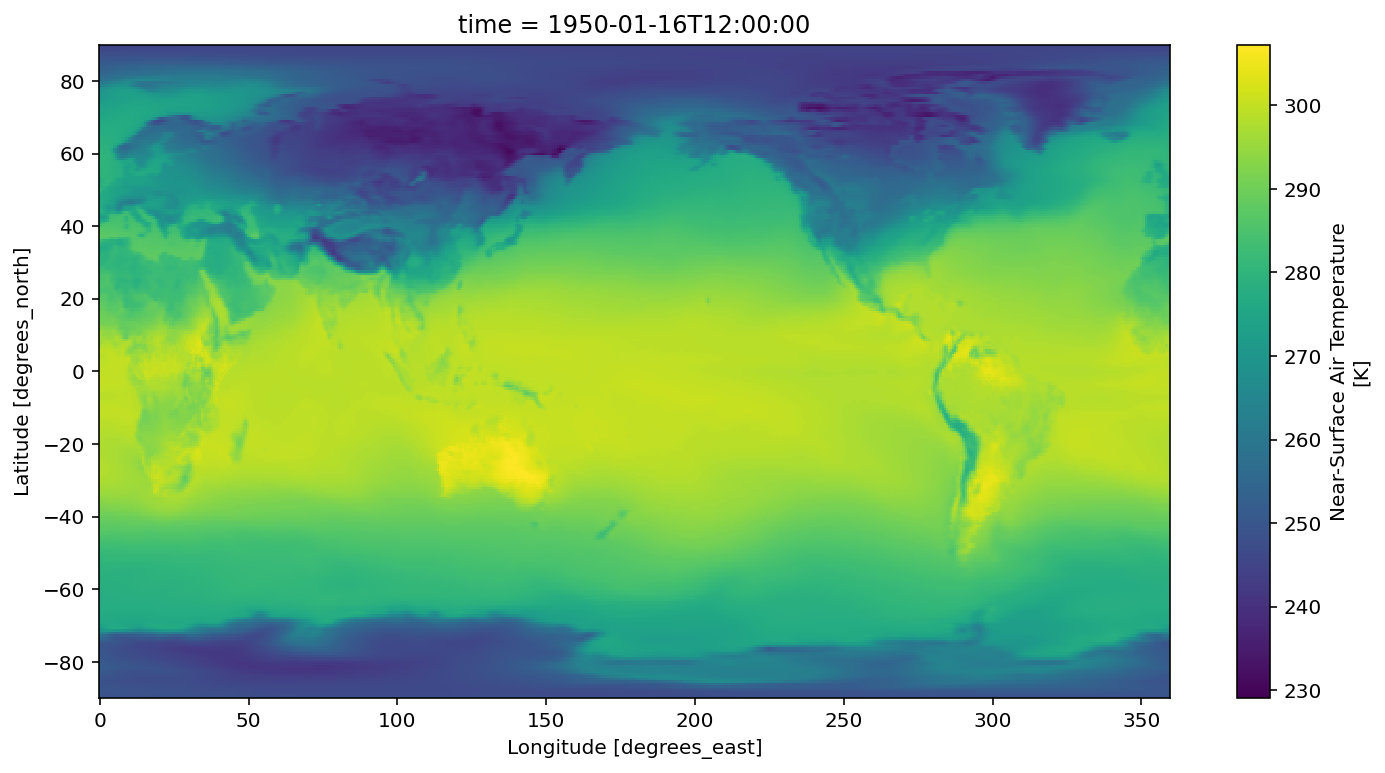

In [17]:
ds_19501 = ds.tas.sel(time='1950-01')
ds_19501.plot()

We can also use the `slice` function to subset based on a range:

In [18]:
ds_1950 = ds.tas.sel(time=slice('1950-01','1950-12'))
# This will show that our time dimension is subsetted to only 12 months
ds_1950

<xarray.DataArray 'tas' (member_id: 1, time: 12, lat: 256, lon: 512)>
dask.array<getitem, shape=(1, 12, 256, 512), dtype=float32, chunksize=(1, 12, 256, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 1950-12-16T12:00:00
Dimensions without coordinates: member_id
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2020-11-27T23:44:46Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

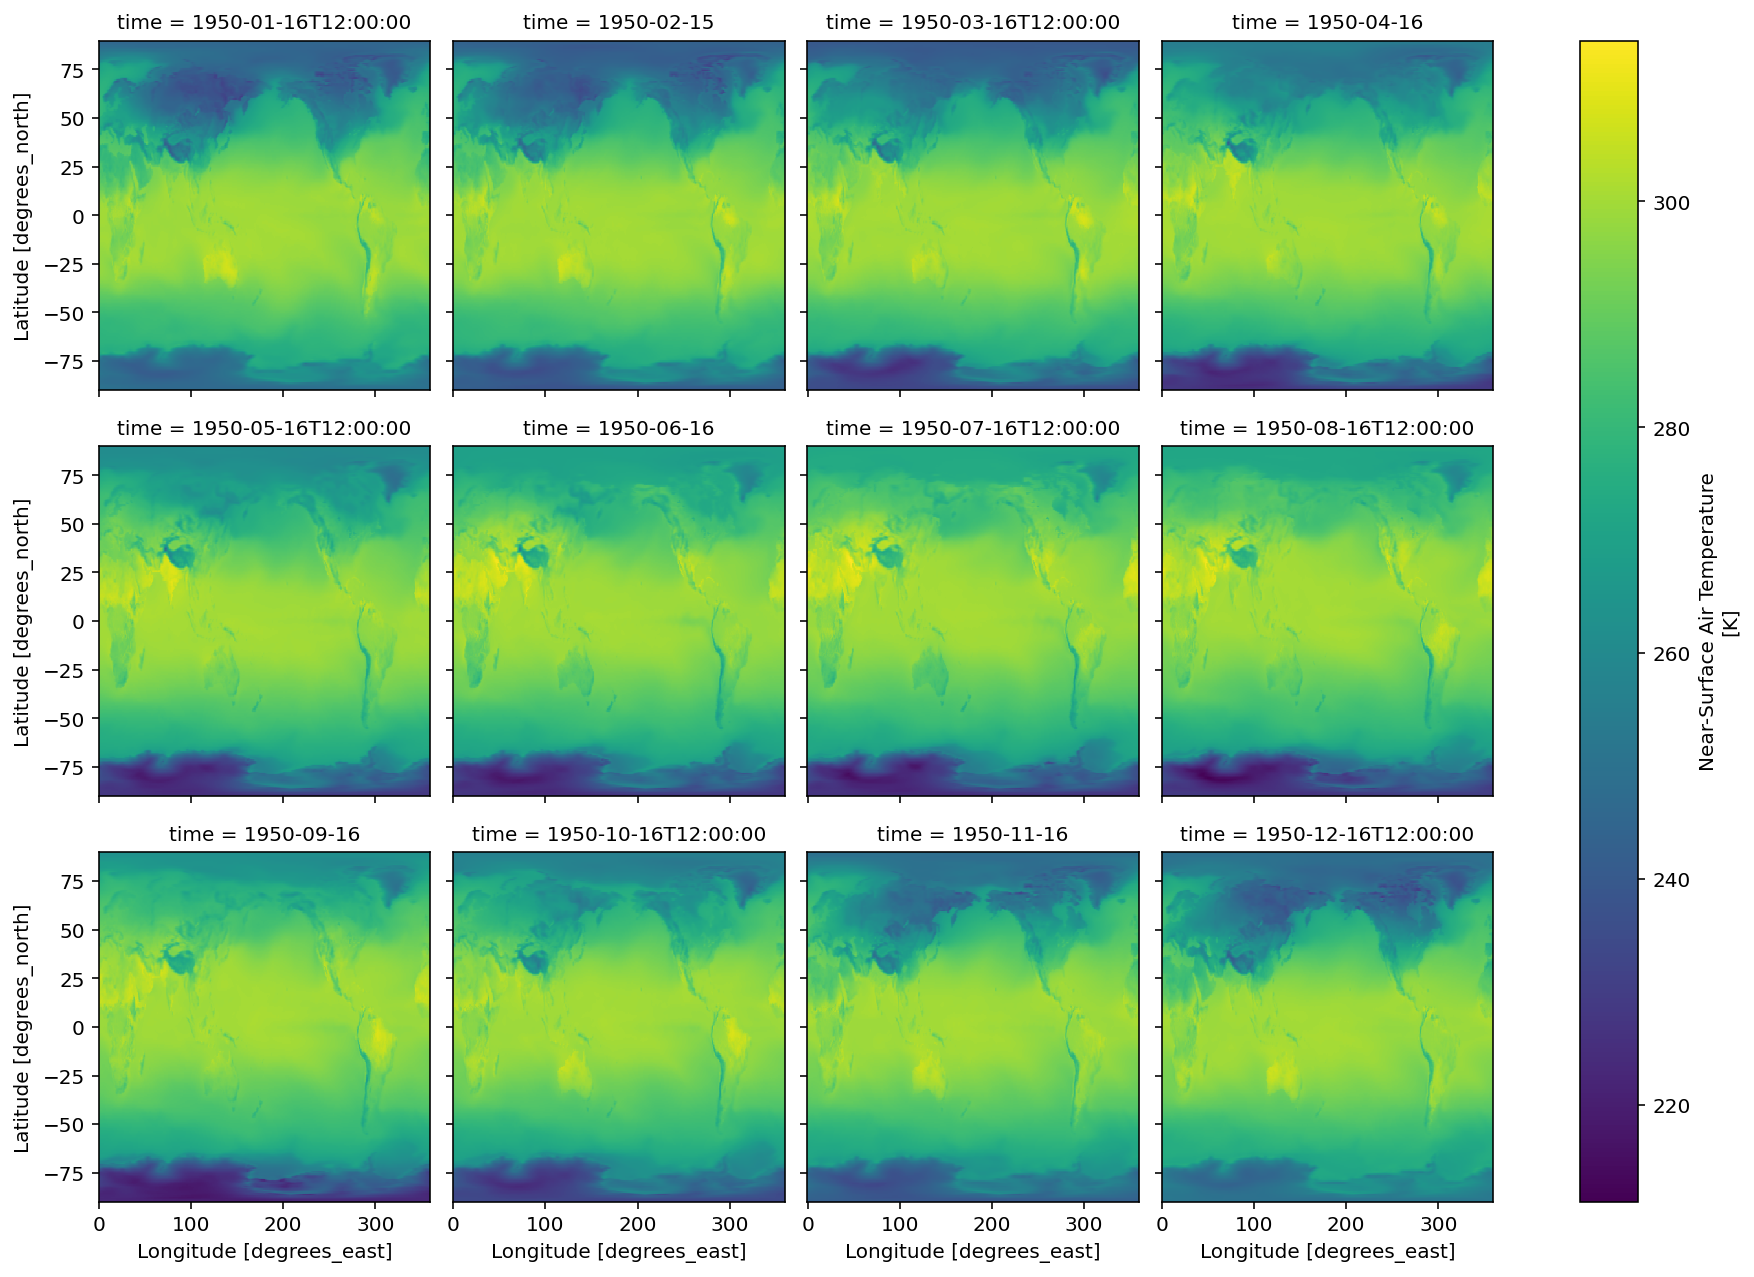

In [19]:
# Now we can plot this by defining multiple panels and specifying the dimensions
ds_1950.plot(x="lon", y="lat", col="time", col_wrap=4)

Similarly we can subset over smaller regions of interest by slicing over the `lat`,`lon` dimensions:

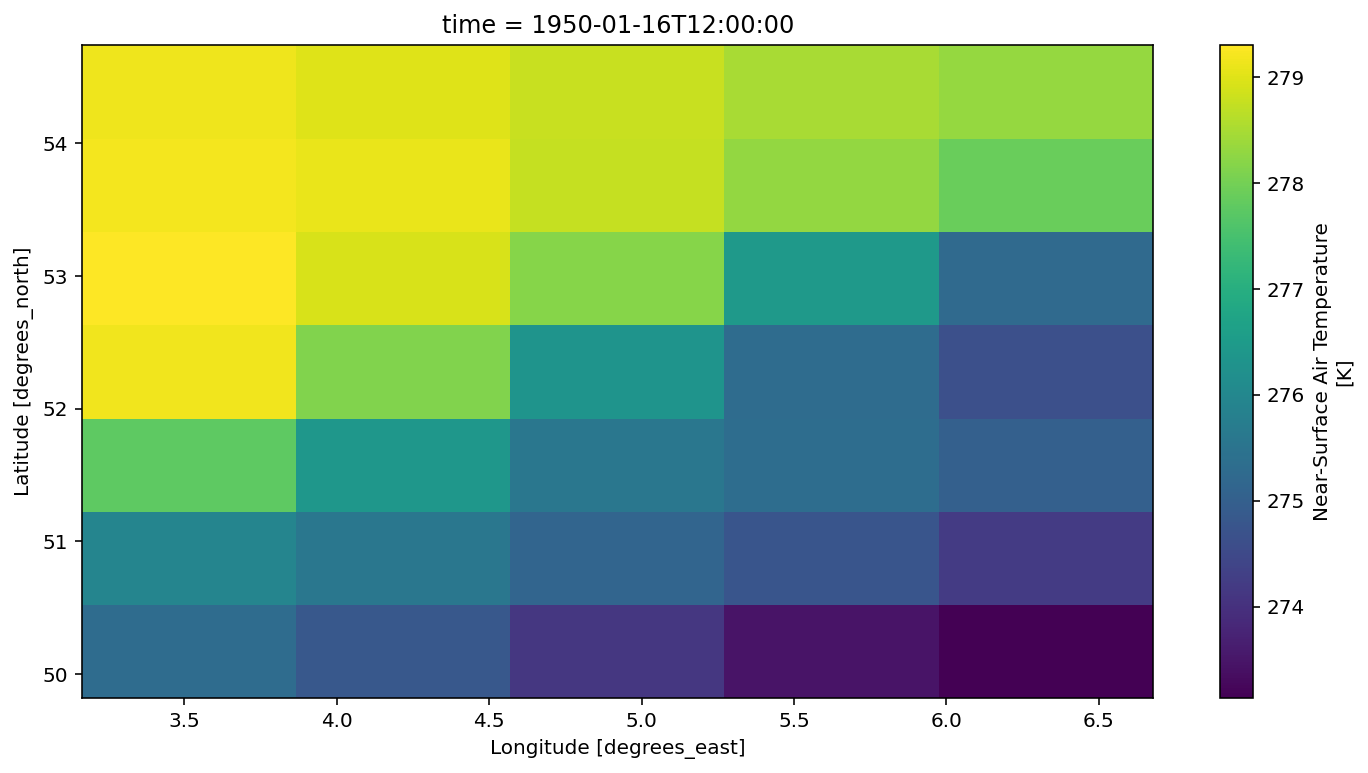

In [20]:
ds_19501.sel(lon=slice(3,7)).sel(lat=slice(50,55)).plot()

### Basic array math
Xarray dats structures also allow to apply functions over dimensions. For example, we can do basic math:

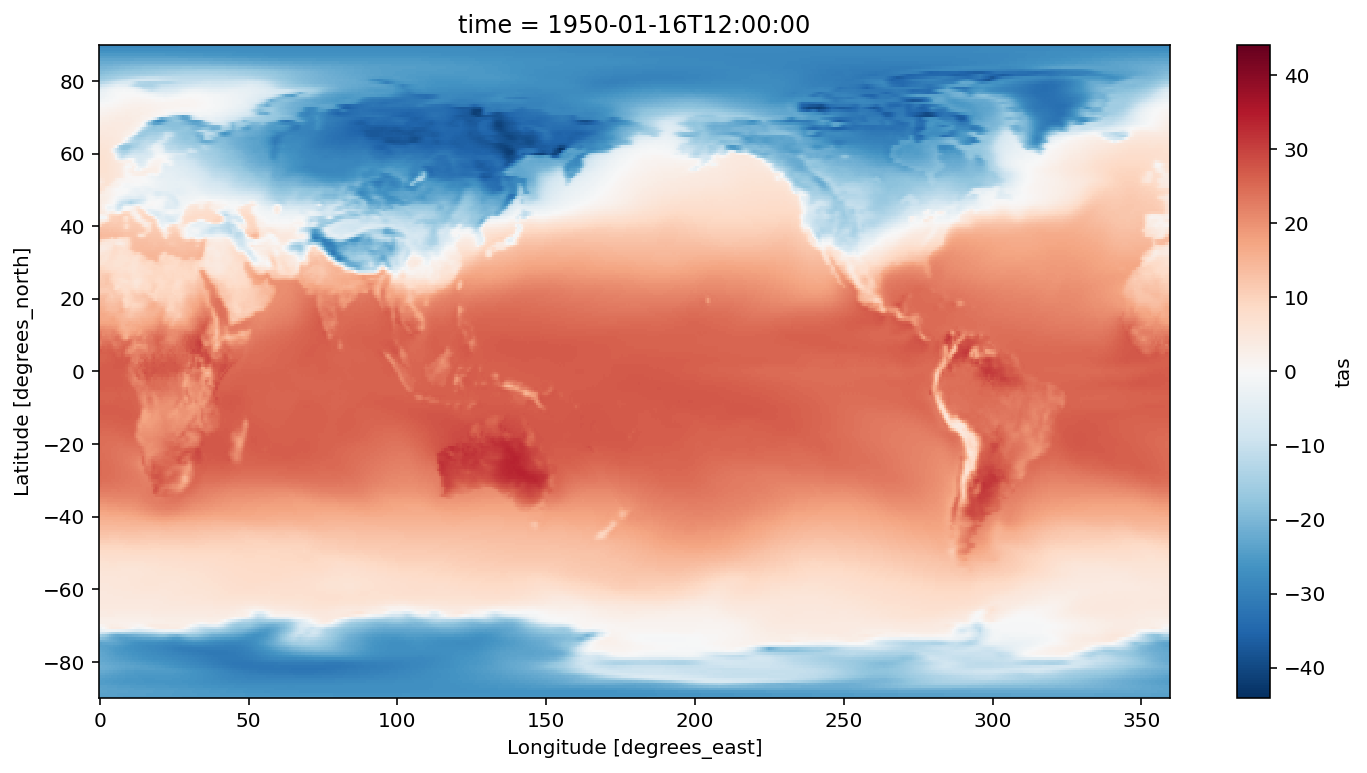

In [23]:
# Calculate temperature in degrees
temp = ds_19501-273.15
temp.plot()

*Or* use `.where()` to do conditional analyses:

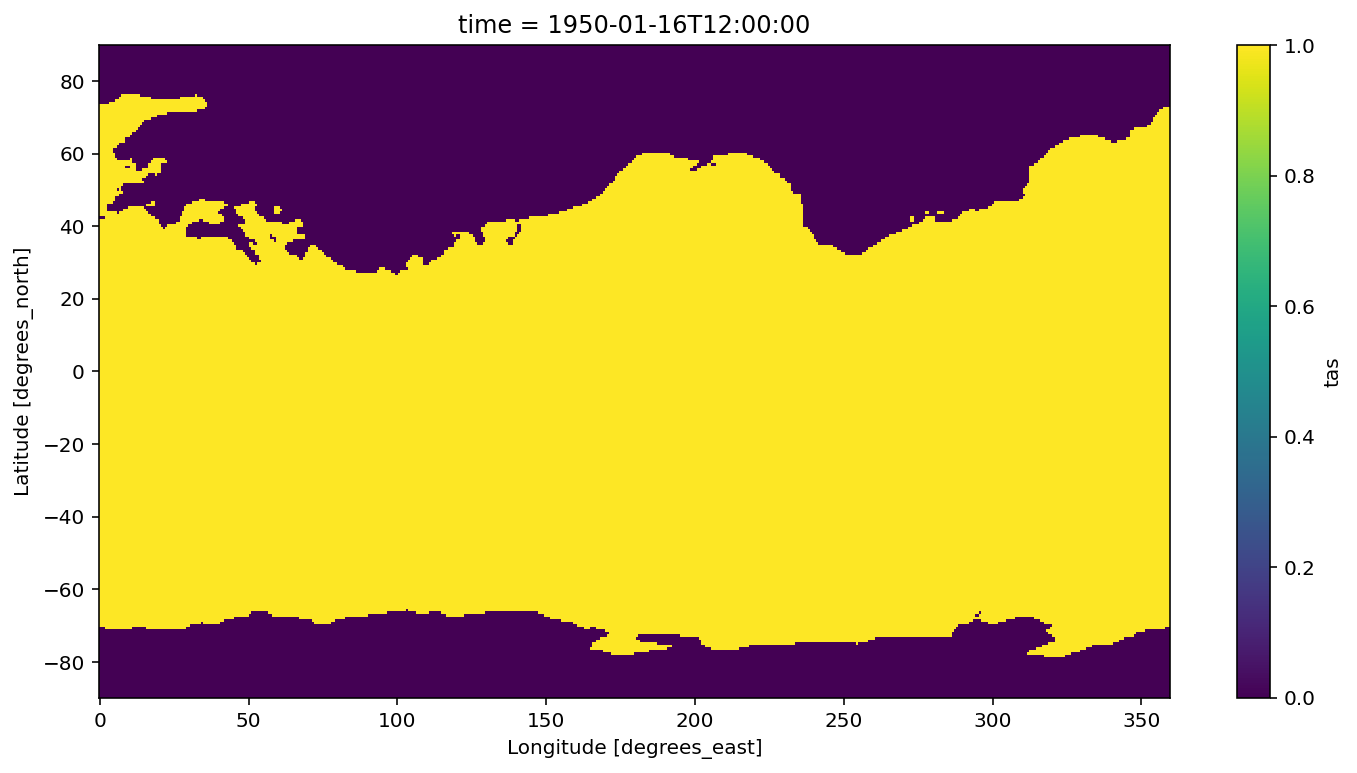

In [24]:
# Identify where temperature are above freezing temperature
xr.where(temp > 0,1,0).plot()

### Aggregation methods
Aggregation methods (e.g. mean, std, min, max) aggregate the data when applied. For example we can calculate the mean, std etc over all grid cells in time/space:

In [25]:
# Maan
tmp = ds_1950.mean()
print('Mean',tmp.values)
# Min
tmp = ds_1950.min()
print('Min',tmp.values)
# Max
tmp = ds_1950.max()
print('Max',tmp.values)
# Std
tmp = ds_1950.std()
print('Std',tmp.values)
# Quantile
tmp = ds_1950.quantile([0.05,0.5,0.95])
print('Q05,Q50,Q95',tmp.values)

Mean 279.33563
Min 211.45274
Max 314.22693
Std 19.846123
Q05,Q50,Q95 [240.32790375 284.42906189 300.16469879]


Or we can do it along a specific dimension:

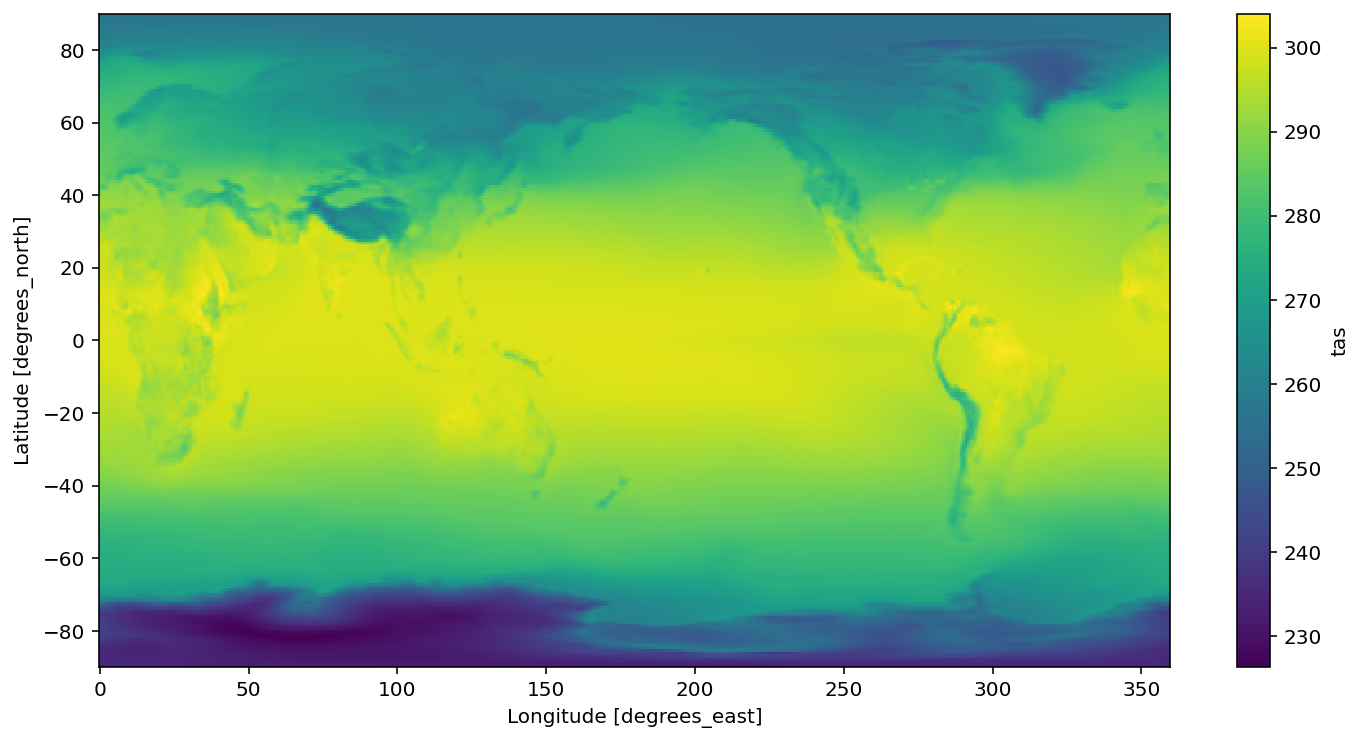

In [26]:
# Calculate mean over time
tmp = ds_1950.mean(dim='time')
tmp.plot()

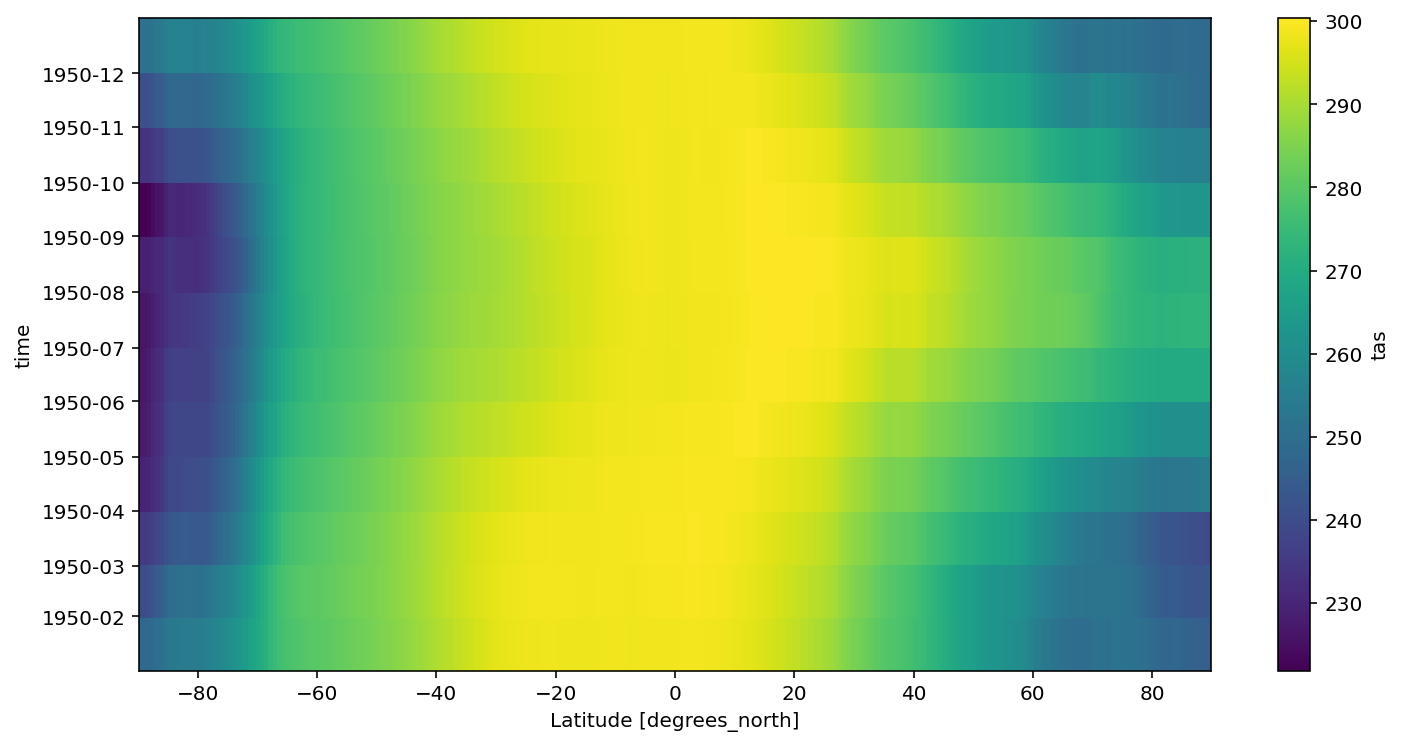

In [27]:
# Calculate mean over longitude
tmp = ds_1950.mean(dim='lon')
tmp.plot() # Which nicely shows the seasonal cycle of temperature over different latitudes

### Rolling operations
Similarly we can also apply rolling operations (e.g. rolling mean) using the `rolling` function. For example, if you want to apply a yearly rolling mean to remove the seasonal cycle:

In [28]:
ds_r = ds.tas.rolling(time=12).mean()
ds_r

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 256, lon: 512)>
dask.array<truediv, shape=(1, 1980, 256, 512), dtype=float64, chunksize=(1, 126, 256, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: member_id
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2020-11-27T23:44:46Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

### Groupby
Xarray also allows to groupy when applying functions.  For example, we can apply a anomaly function and apply to every month. In this case we calculate a  month's value (e.g. Jan) minus the mean for all similar months (e.g. all January's)

/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


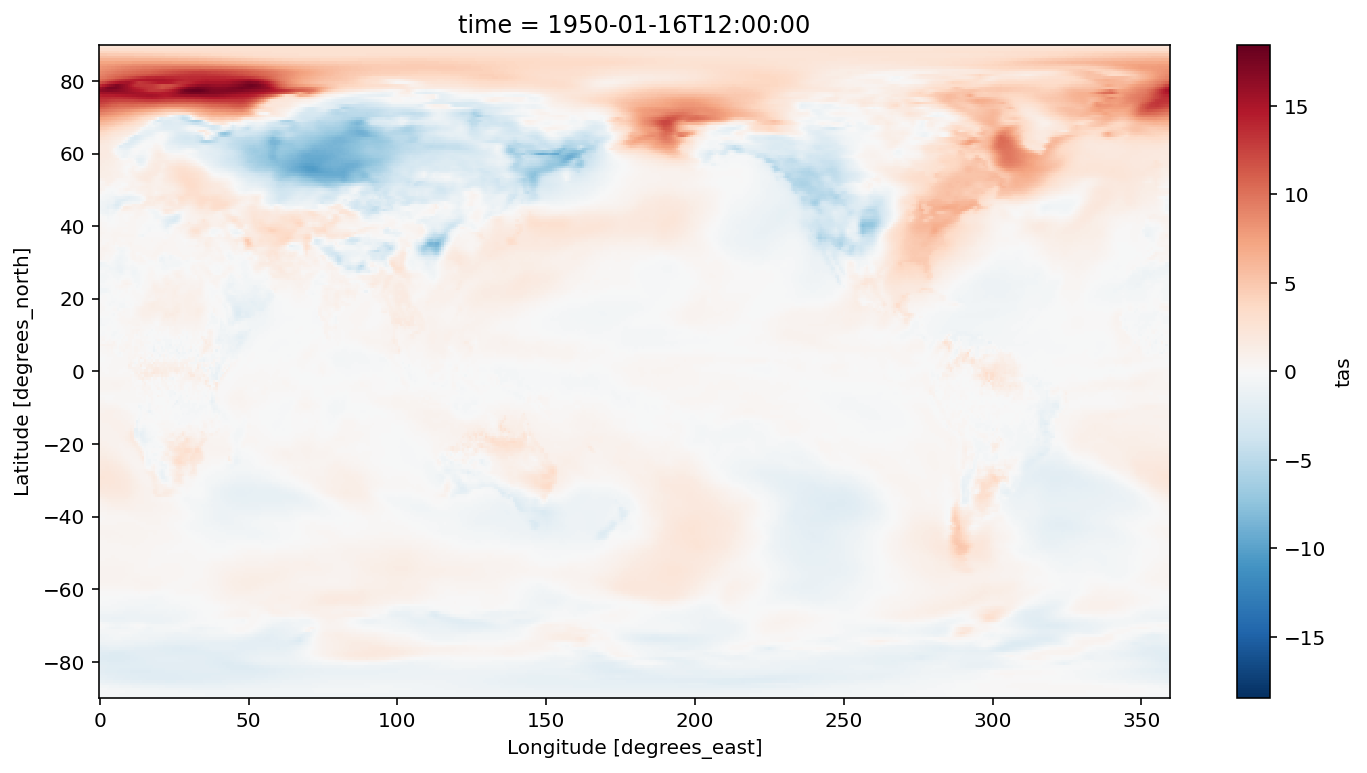

In [29]:
# Define anomaly function
def anomaly(x):
    return (x - x.mean(dim='time'))
# Group dataset per month and apply anomaly function using map command
anom = ds.tas.groupby("time.month").map(anomaly)
# Plot 
anom.sel(time='1950-01').plot()


Or we can simply apply aggregation methods:

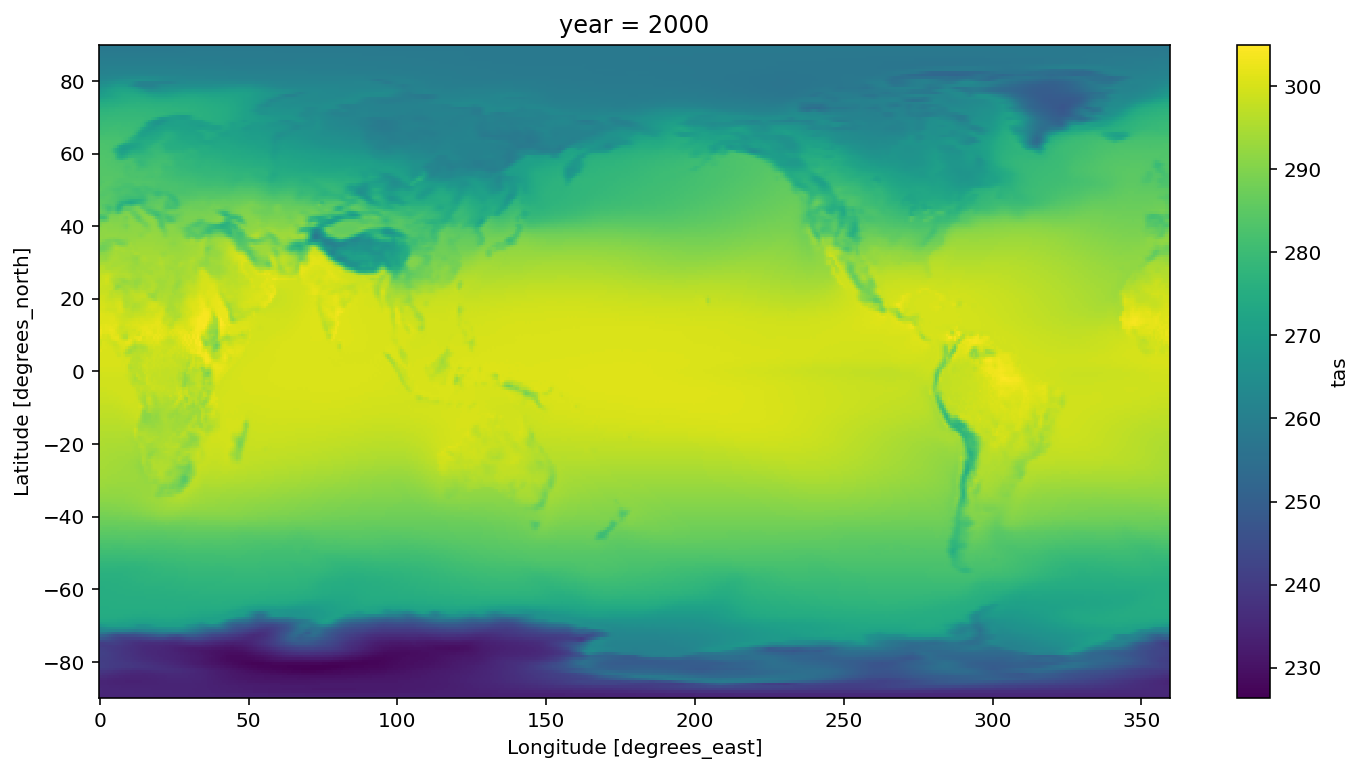

In [30]:
mon = ds.tas.groupby("time.year").mean()
# Plot 
mon.sel(year=2000).plot()

### Fitting polynomimials
Xarray objects also allow performing linear or polynomial regressions using the least-squares method. polyfit() computes the best fitting coefficients along a given dimension and for a given order:

In [31]:
lm = ds_r.polyfit(dim="time", deg=1, full=True)
lm

<xarray.Dataset>
Dimensions:               (degree: 2, lat: 256, lon: 512, member_id: 1)
Coordinates:
  * degree                (degree) int64 1 0
  * member_id             (member_id) int64 0
  * lat                   (lat) float64 -89.46 -88.77 -88.07 ... 88.77 89.46
  * lon                   (lon) float64 0.0 0.7031 1.406 ... 357.9 358.6 359.3
Data variables:
    time_matrix_rank      int64 2
    time_singular_values  (degree) float64 1.272 0.6176
    polyfit_coefficients  (degree, member_id, lat, lon) float64 dask.array<chunksize=(2, 1, 256, 512), meta=np.ndarray>
    polyfit_residuals     (member_id, lat, lon) float64 dask.array<chunksize=(1, 256, 512), meta=np.ndarray>

Subsequently, we can use the coefficients `polyfit_coefficients` and residuals `polyfit_residuals`. For example, we can now plot the linear trend:

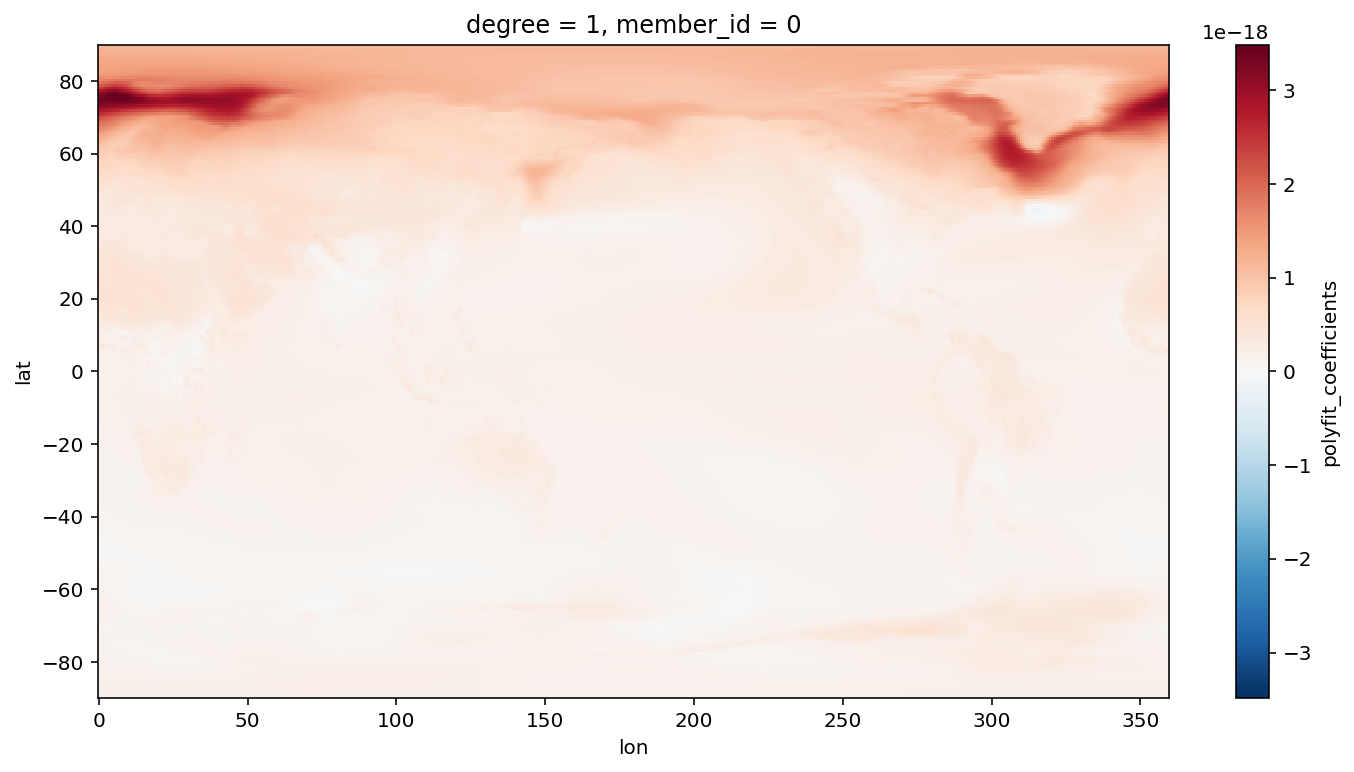

In [32]:
# Trend
lm.polyfit_coefficients[0].plot()

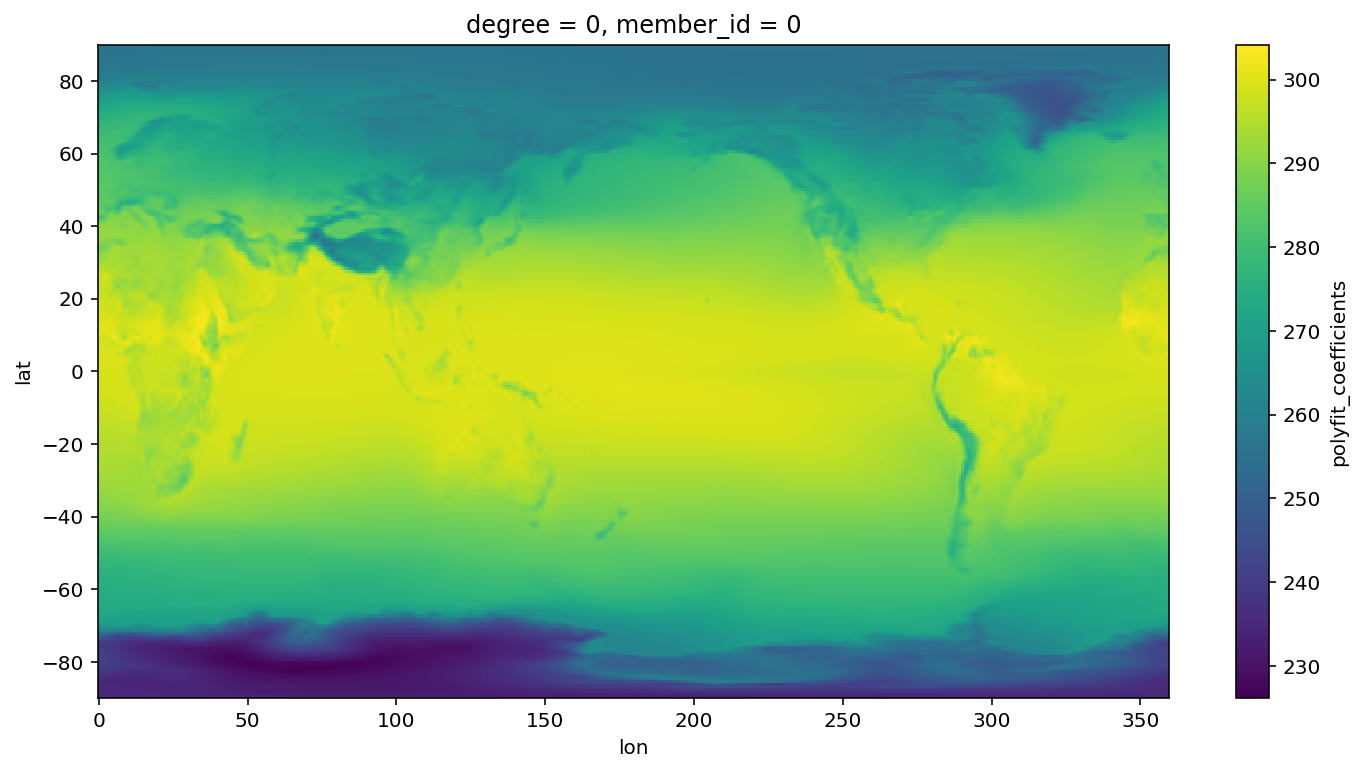

In [33]:
# Offset
lm.polyfit_coefficients[1].plot()

### Area averages
One of the important things to take into account when working with climate model data is that degree based grid cells do not cover equal areas (e.g. grid cells at the poles are smaller than at the equator following the `cos` of the latitude. Therefore, when calculating area averages (e.g. global mean), we have to take this into account. We can do this by first calculating the weights and calculating the weighted average:

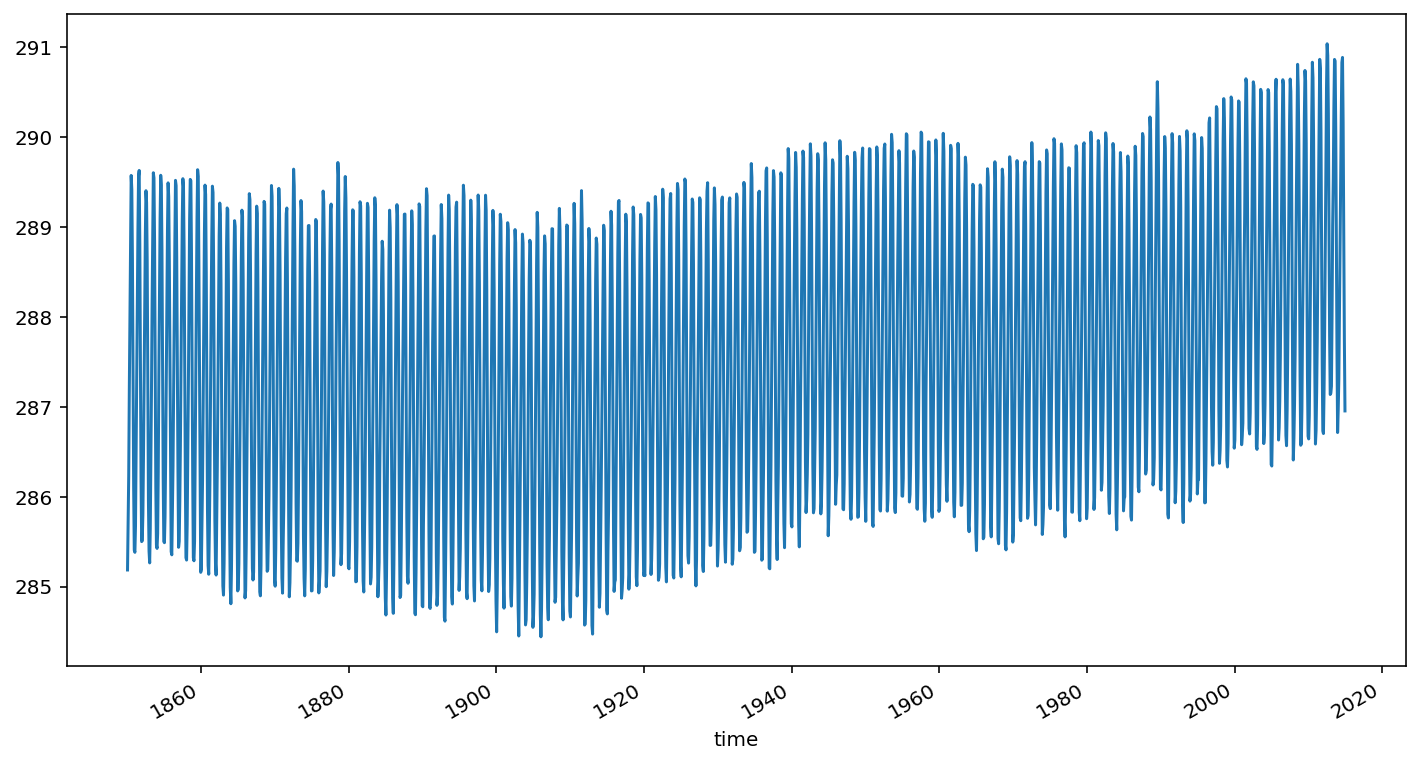

In [34]:
cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
gm = (ds.tas* cos_lat_2d).sum(dim=['lat','lon']) /cos_lat_2d.sum(dim=['lat','lon']) # calculate weighted average
gm.plot()

Or plot the time series of anomalies:

In [39]:
gma = (anom* cos_lat_2d).sum(dim=['lat','lon']) /cos_lat_2d.sum(dim=['lat','lon']) # calculate weighted average
gma.plot()

### Lazy computing
Xarray relies on dask and lazy execution, which means that the code is only executed when an output is needed (e.g. to plot). This means that intermediate variables are not saved and that, for example, the whole chain of commands is executed every time you run `gma.plot()`. This may be time consuming so sometimes it might be beneficial to store the data in cache. In that way the output is saved and does not need to be recalculated every time your perform an analysis. You can force this easily with `.compute()`

1 loop, best of 5: 10.5 s per loop


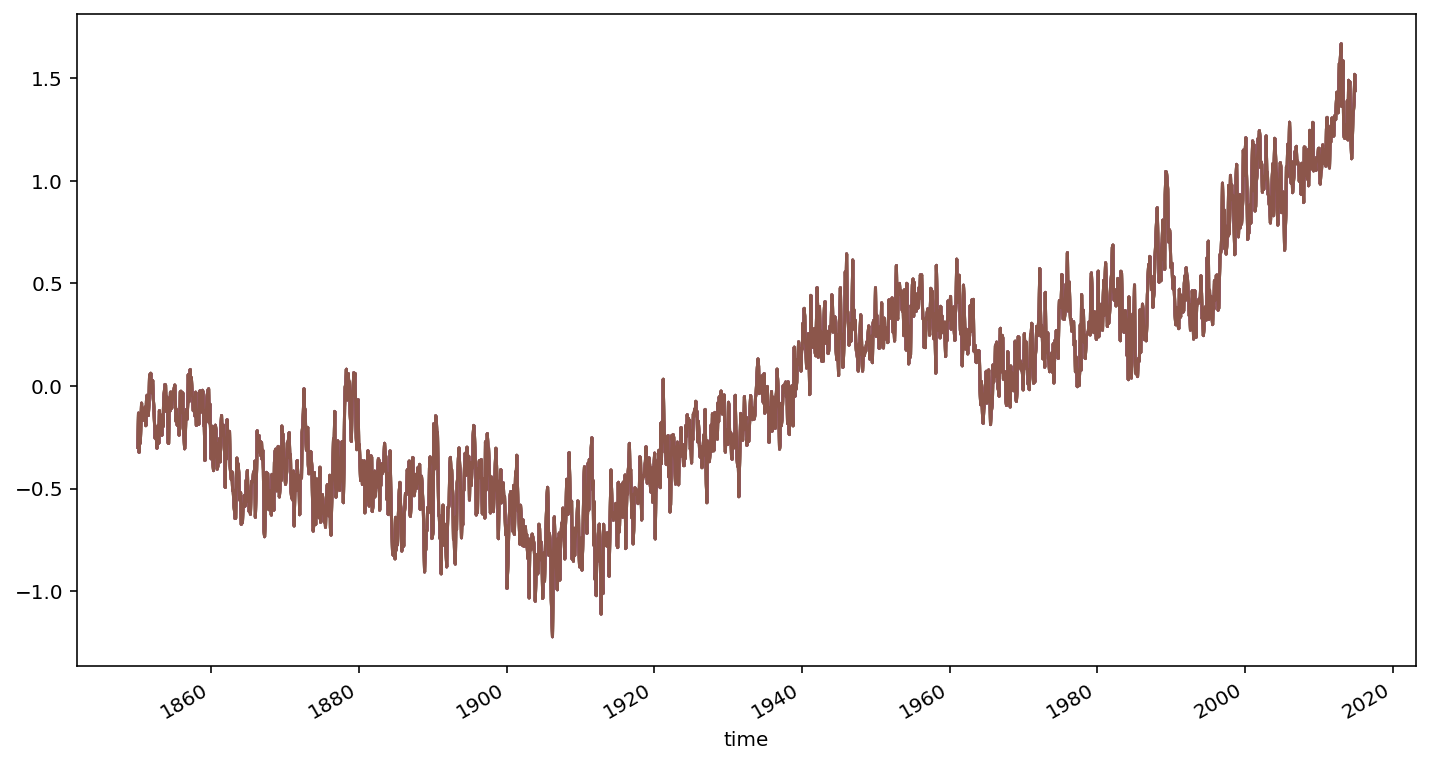

In [41]:
# before compute it takes long
gma.plot()

In [43]:
# Computing also takes long
gma = gma.compute()
gm = gm.compute()

The slowest run took 8.02 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 5: 4.77 ms per loop


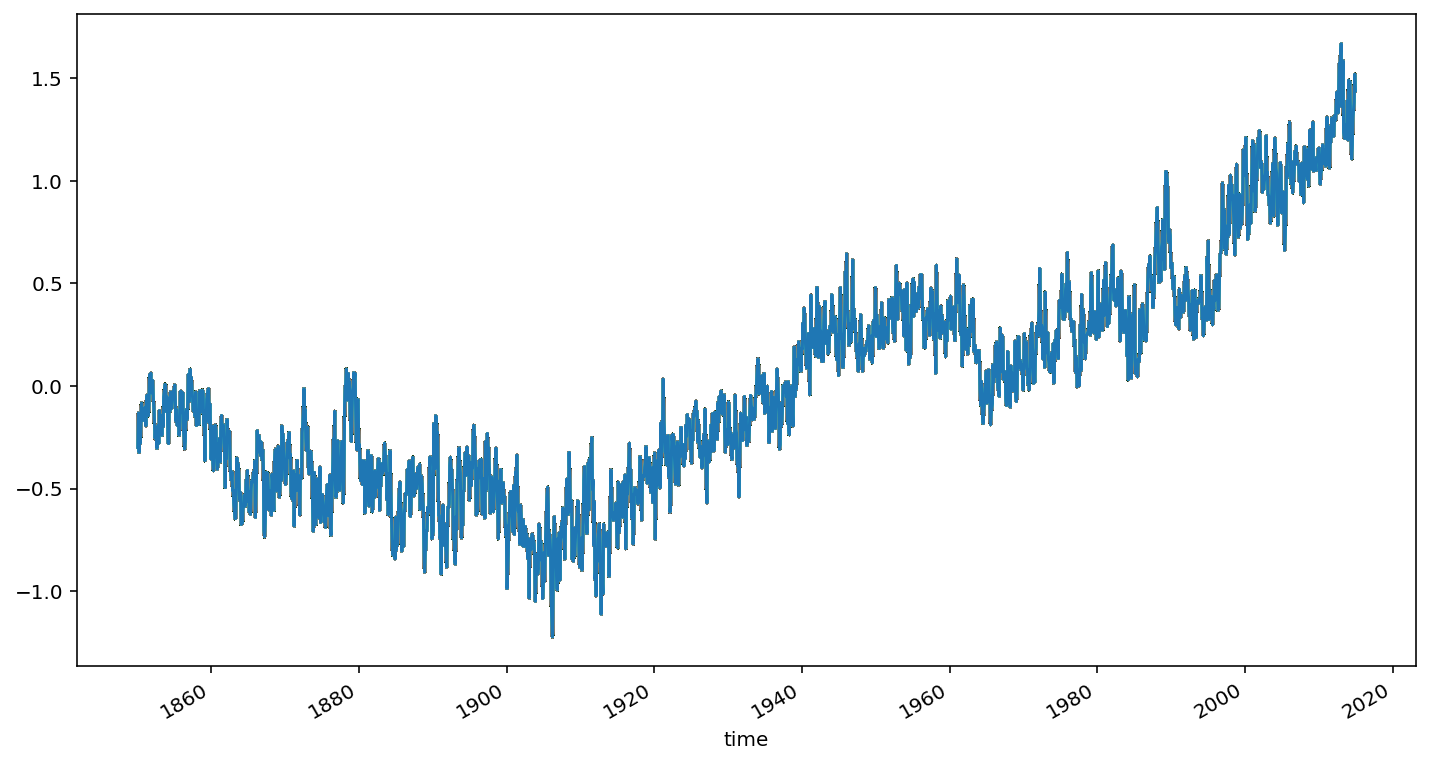

In [44]:
# But plotting now should  become faster
gma.plot()

## Plotting xarray output

The [xarray website](https://xarray.pydata.org/en/stable/plotting.html) gives excellent clarification on how to tune your plots, but see below some examples for basic functionalities

### Combining plots
By using the subplot command you can combine multiple plots:

Text(0.5, 1.0, 'Monthly mean temperature anomaly')

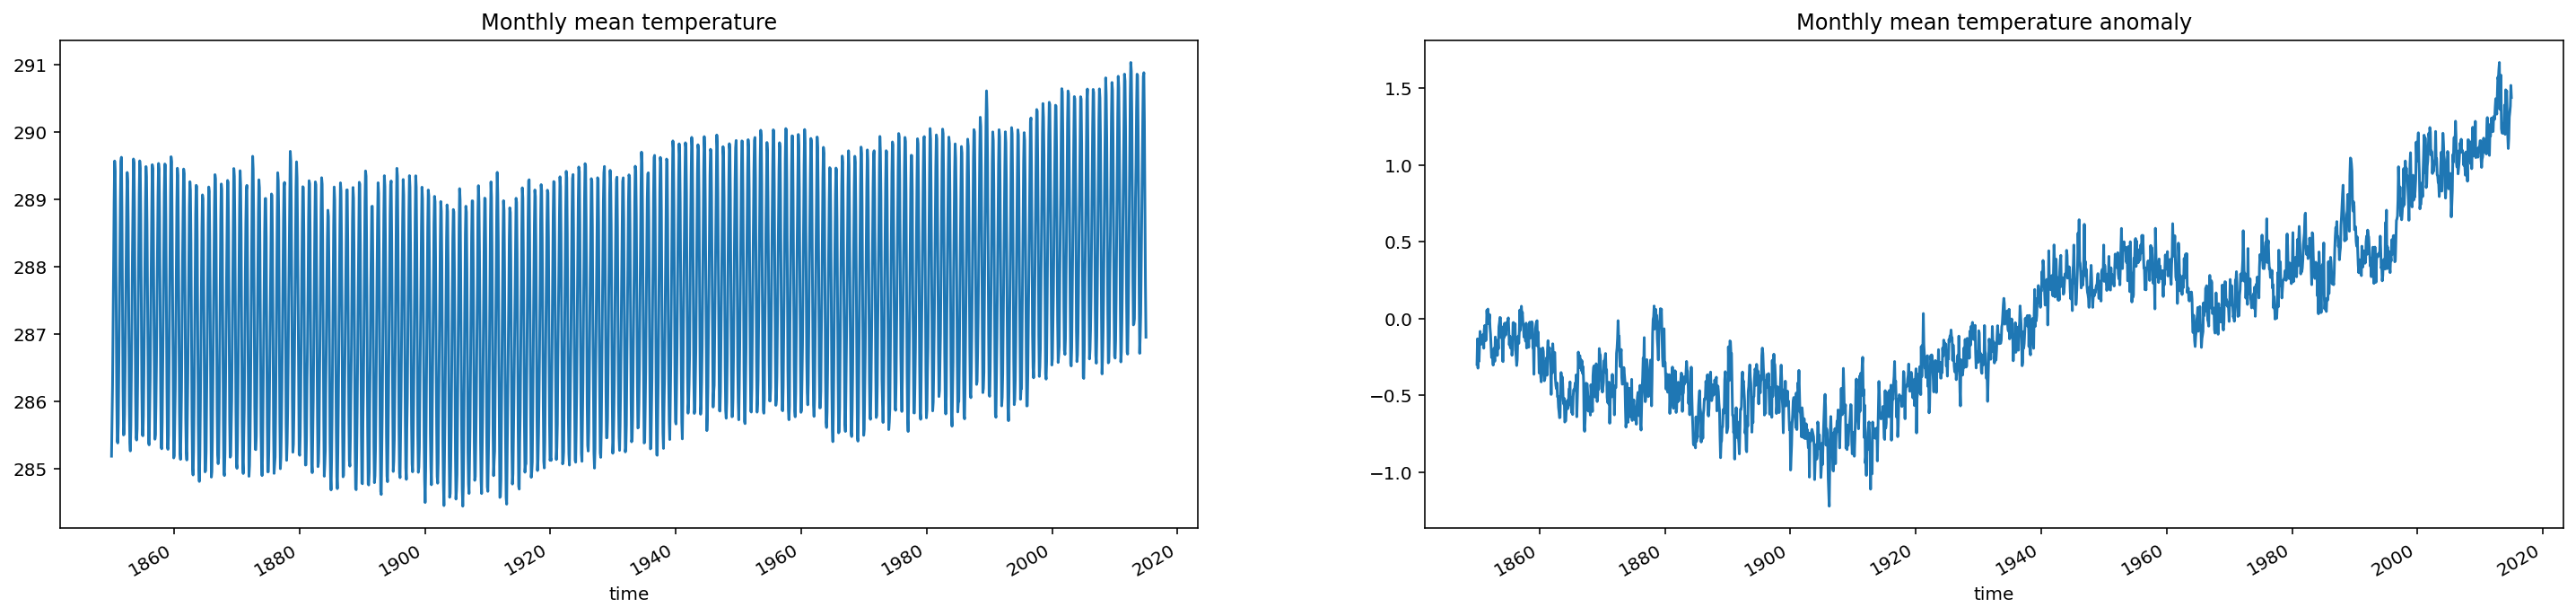

In [48]:
fig, axes = plt.subplots(ncols=2,figsize=(25,5))
print(axes)
gm.plot(ax=axes[0])
axes[0].set_title('Monthly mean temperature')
gma.plot(ax=axes[1])
axes[1].set_title('Monthly mean temperature anomaly')

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0, 0.5, 'Monthly mean temperature anomaly')

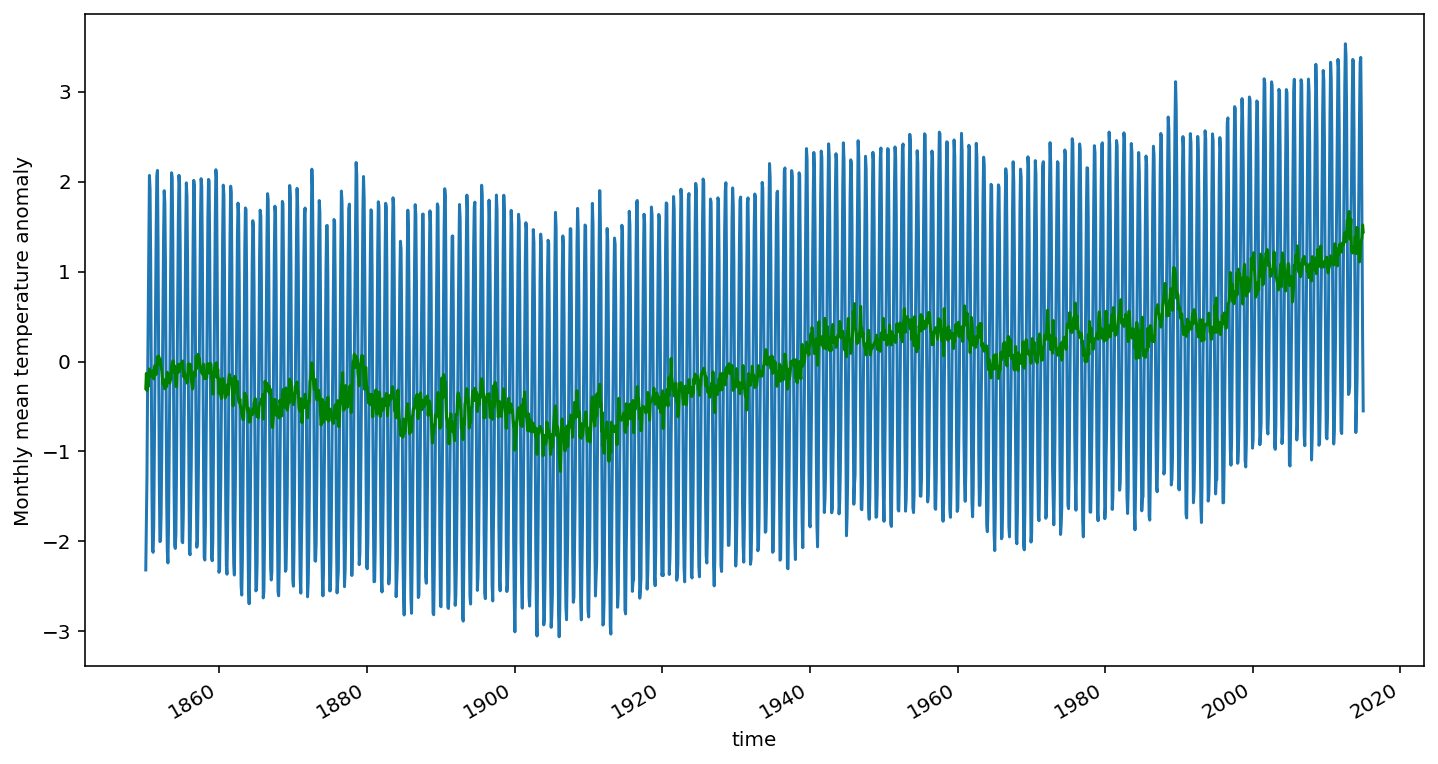

In [49]:
fig, axes = plt.subplots(ncols=1)
print(axes)
(gm-gm.mean()).plot(ax=axes)
gma.plot(ax=axes,color='green')
axes.set_ylabel('Monthly mean temperature anomaly')


### Maps

To finetune your maps, you can use the different [cartopy projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html), where it important to realize that The projection argument is used when creating plots and determines the projection of the resulting plot.
The transform argument to plotting functions tells Cartopy what coordinate system your data are defined in.



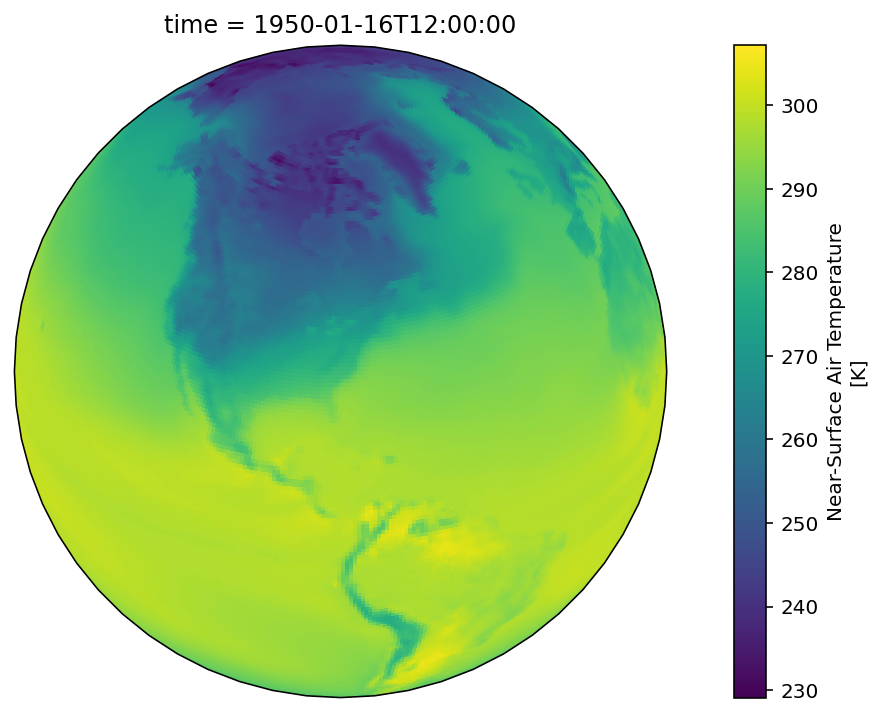

In [50]:
ds_19501.plot(transform=ccrs.PlateCarree(), # This is the projection of the data in lat/lon
              subplot_kws={"projection": ccrs.Orthographic(-80, 35)}) # Here you define the desired projection using cartopy projection definitions

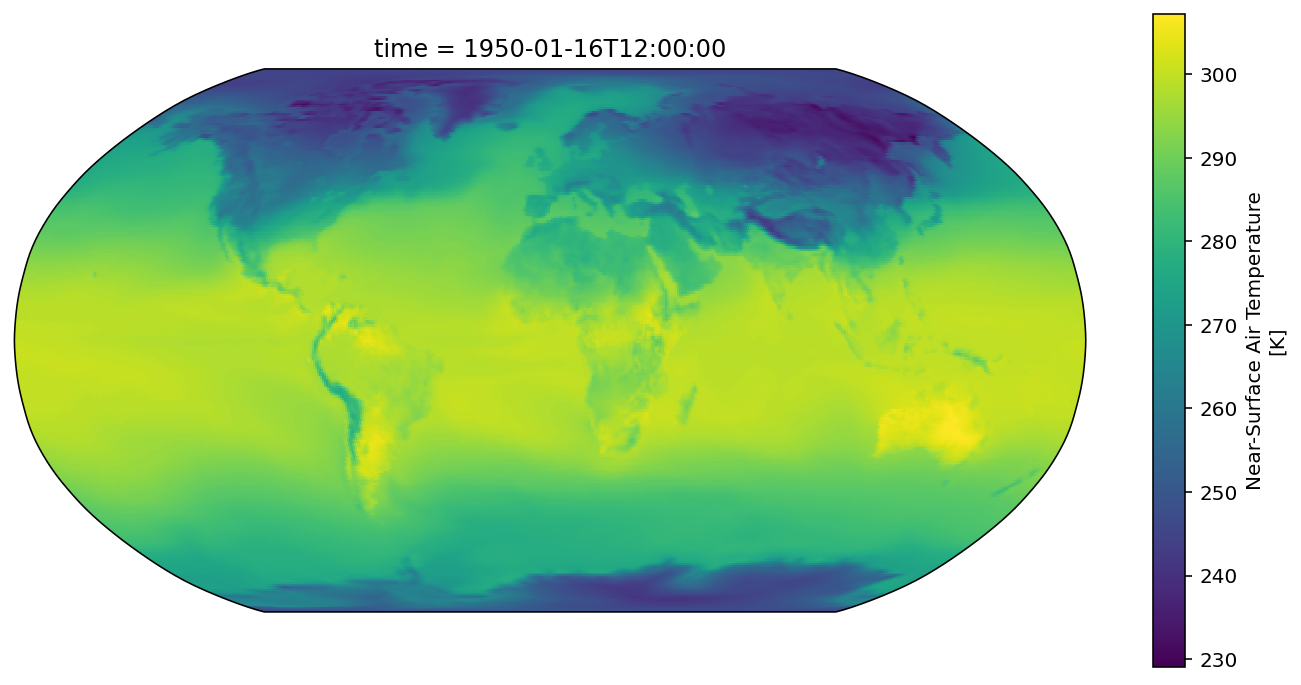

In [51]:
ds_19501.plot(transform=ccrs.PlateCarree(), # This is the projection of the data in lat/lon
              subplot_kws={"projection": ccrs.Robinson()}) # Here you define the desired projection using cartopy projection definitions

Subsequently, you can use cartopy's features functions. For example, to add coastlines or gridlines:

Text(0.5, 1.0, 'Test')

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


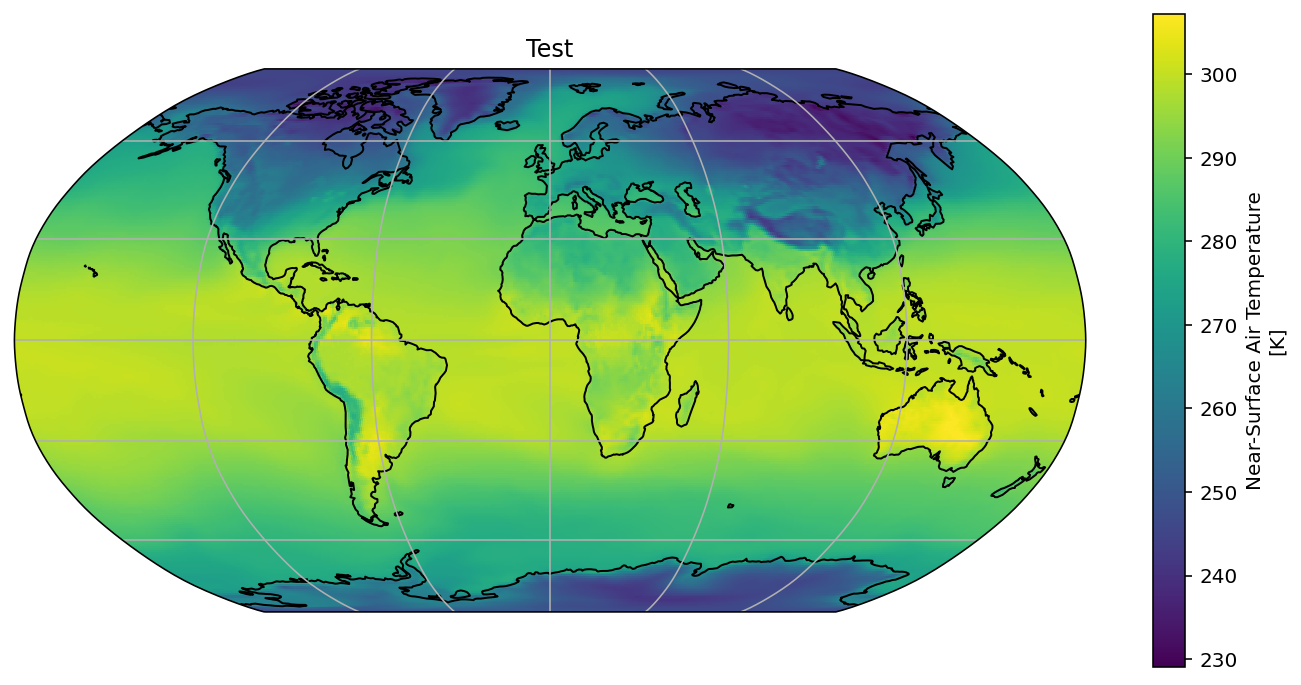

In [52]:
p = ds_19501.plot(transform=ccrs.PlateCarree(), subplot_kws={"projection": ccrs.Robinson()})
p.axes.gridlines()
p.axes.coastlines()
p.axes.set_title('Test')

Similarly to in cartopy we can subset the data subsequently by using `set_extent`:


Text(0.5, 1.0, 'Test Europa')

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


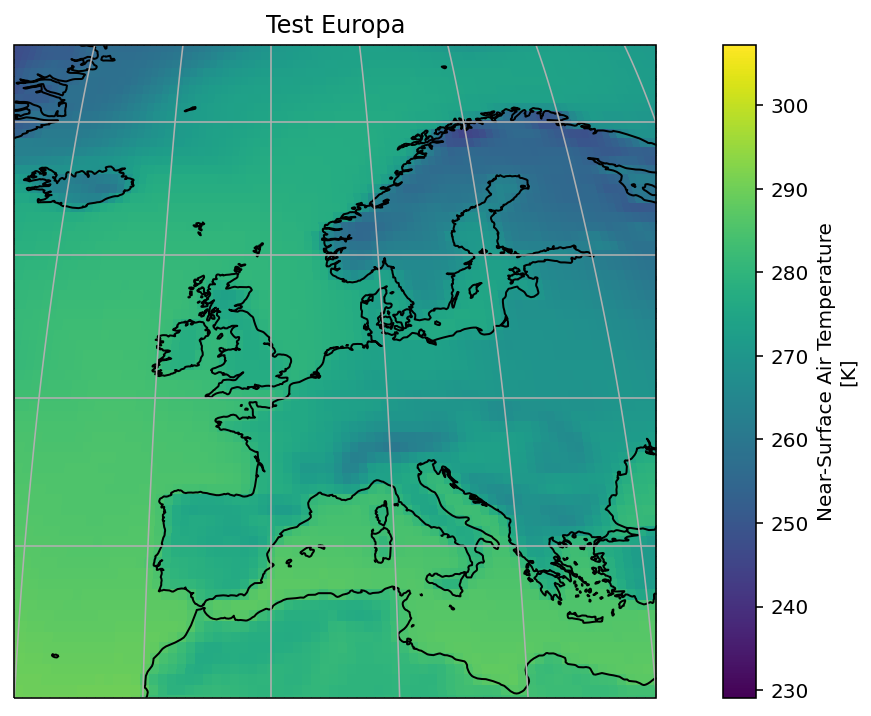

In [53]:
p = ds_19501.plot(transform=ccrs.PlateCarree(), subplot_kws={"projection": ccrs.Robinson()})
p.axes.gridlines()
p.axes.coastlines()
p.axes.set_extent([-20, 30, 30, 75])
p.axes.set_title('Test Europa')

### Colormaps
By default xarray selects a colormap, but you can also specificy it manually by selecting one of the [colormaps op matplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html). For a list of colormaps, check the https://matplotlib.org/stable/tutorials/colors/colormaps.html website and (if you are interested) check the artile of Crameri et. al. on [The misuse of colour in science communication](https://www.nature.com/articles/s41467-020-19160-7)

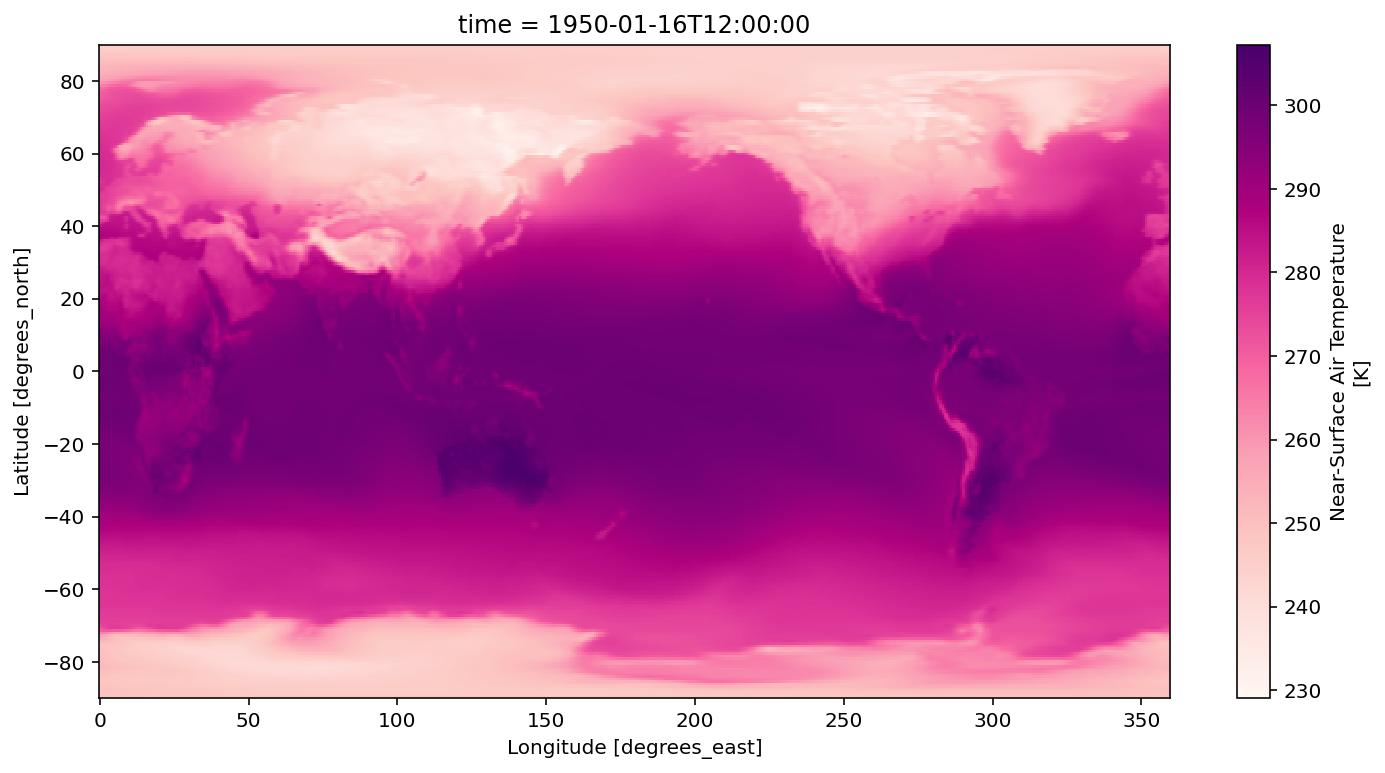

In [54]:
p = ds_19501.plot(cmap=plt.get_cmap('RdPu'))

### Histograms
Another often useful plotting method is the use of histograms. For example, you can calculate the histogram of the temperature anomalies

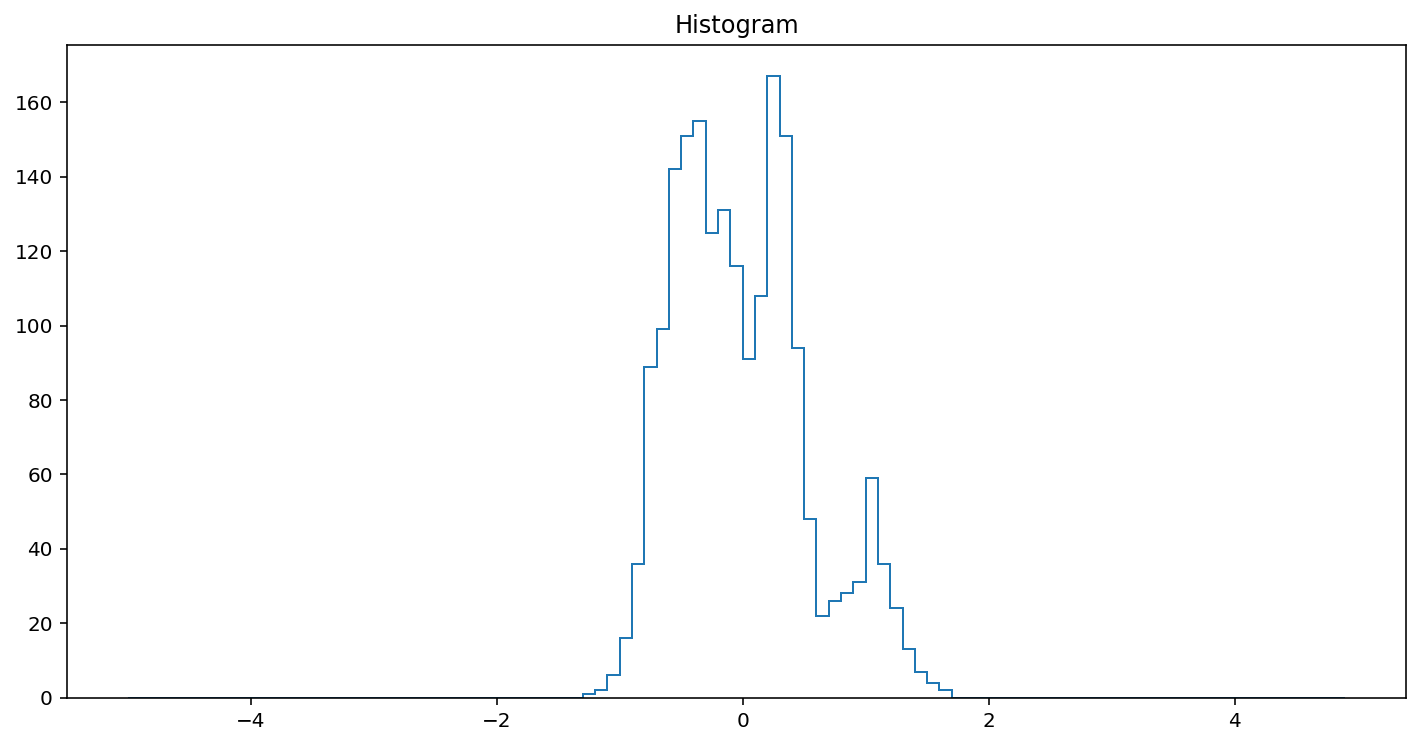

In [55]:
# First define the bins over which to calculate the histogram
bins = np.arange(-5,5,0.1)
n, x, y = xr.plot.hist(gma,bins=bins,histtype=u'step')

Using histograms we can also visualize change in distributions:

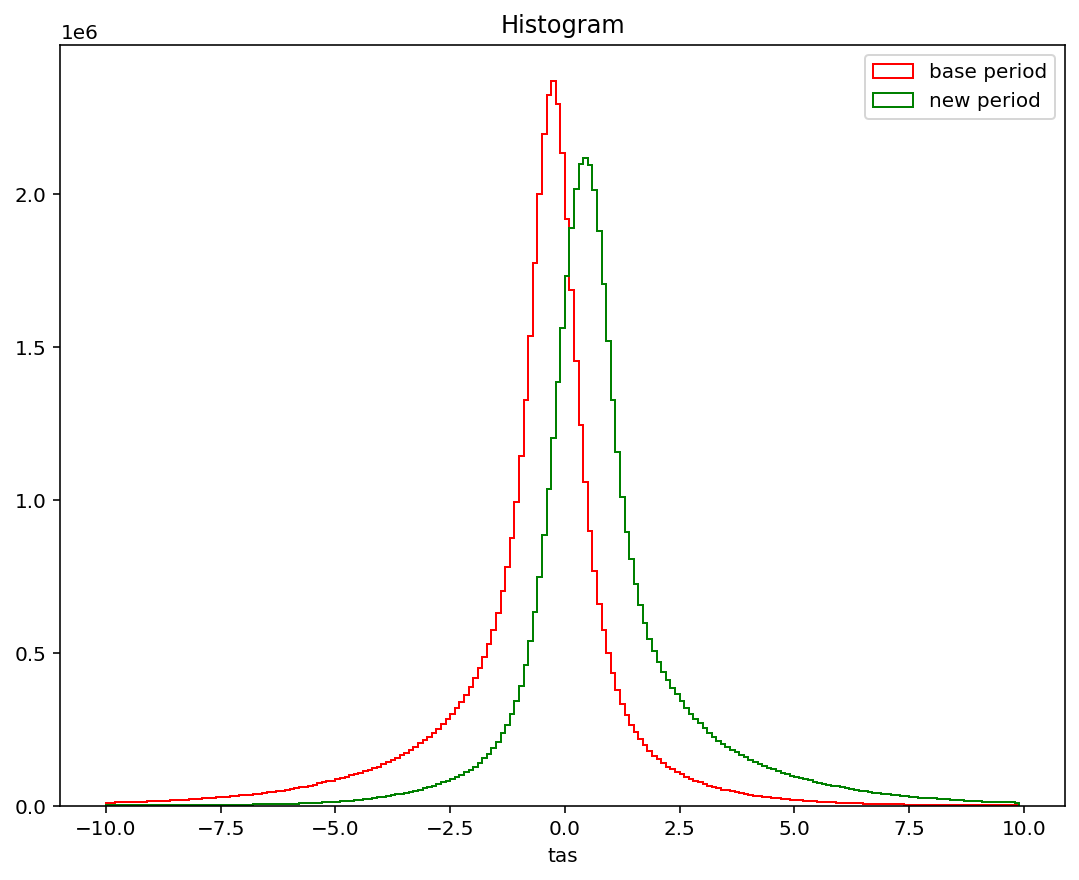

In [56]:
# Define bins
bins = np.arange(-10,10,0.1)
# setup figure 
fig, ax = plt.subplots(1, 1, figsize=(9,7)) 
# Add first histogram (1900-1930)
n, x, y = xr.plot.hist(anom.sel(time=slice('1900','1930')),bins=bins,ax=ax,histtype=u'step',color='red',label='base period')
# Add second histogram (1980-2010)
n, x, y = xr.plot.hist(anom.sel(time=slice('1980','2010')),bins=bins,ax=ax,histtype=u'step',color='green',label='new period')
plt.legend()

## Apply on all models
So far we have focused our analysis on one model only, but we can off course also apply a for-loop to apply it on all models:

In [57]:
# Make empty dictionary for output
ds_anom_dict = {}
# Loop over dictionary of models
for name, ds in tqdm(ds_dict.items()):
    try:
        # calculate monthly anomaly
        ds_anom = ds.groupby('time.month').map(anomaly).compute()
        # substract base period mean
        ds_anom = ds_anom - ds_anom.sel(time=slice('1900','1950')).mean(dim='time')
        # # convert to annual anomalies
        ds_aanom = ds_anom.groupby('time.year').mean(dim='time')

        ds_anom_dict[name] = ds_aanom.compute()
    except:
        continue

ds_anom_dict

  0%|          | 0/53 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]
/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
  2%|▏         | 1/53 [00:06<05:42,  6.58s/it]/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 164 times more chunks
  return self.array[key]
/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]
  4%|▍         | 2/53 [00:15<06:08,  7.22s/it]/usr/local/lib/python3.7/dist-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is gener

{'CMIP.AS-RCEC.TaiESM1.historical.Amon.gn': <xarray.Dataset>
 Dimensions:    (bnds: 2, lat: 192, lon: 288, member_id: 1, year: 165)
 Coordinates:
     height     float64 2.0
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
     lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
     lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
   * member_id  (member_id) <U8 'r1i1p1f1'
   * year       (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
 Dimensions without coordinates: bnds
 Data variables:
     tas        (year, member_id, lat, lon) float32 -0.452 -0.4488 ... 3.557,
 'CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn': <xarray.Dataset>
 Dimensions:    (bnds: 2, lat: 192, lon: 384, member_id: 1, year: 164)
 Coordinates:
     height     float64 2.0
   * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
    

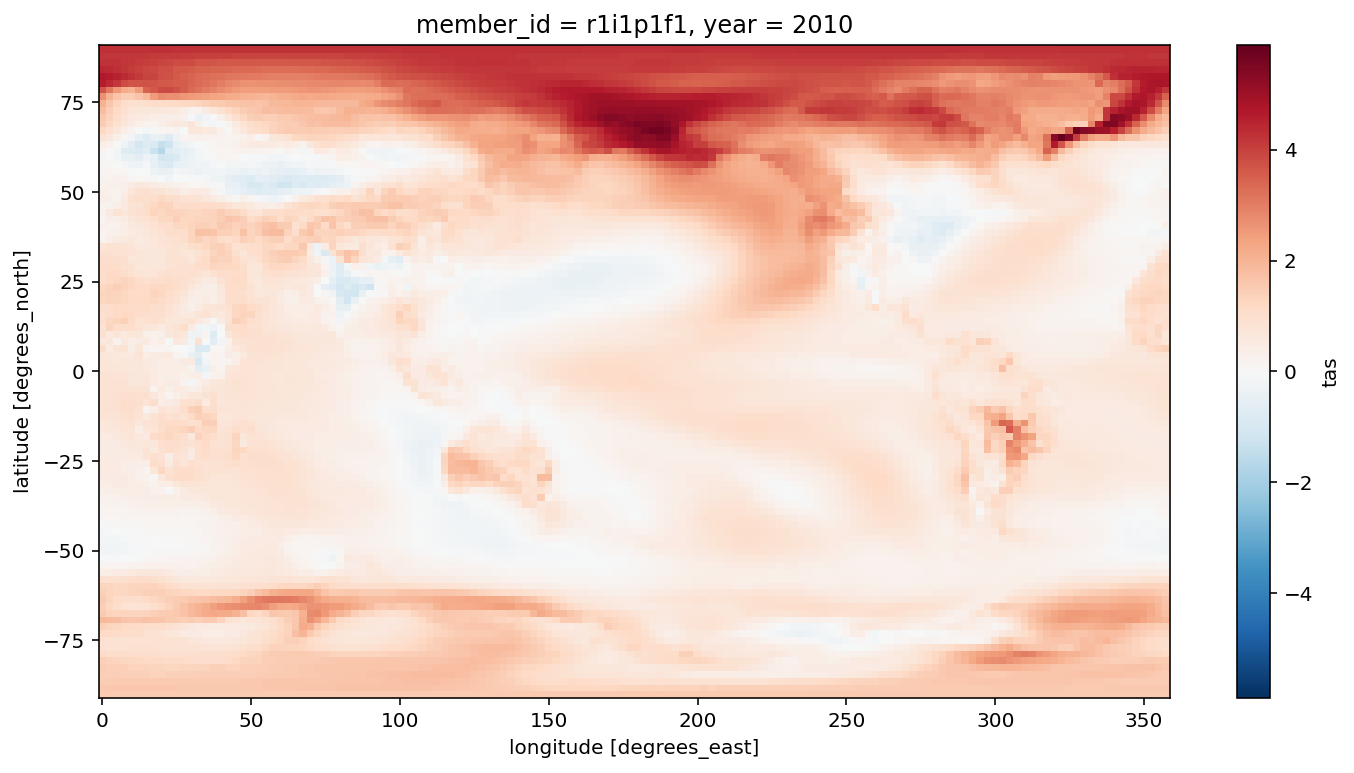

In [58]:
ds_anom_dict['CMIP.NCAR.CESM2-FV2.historical.Amon.gn'].tas.sel(year=2010).plot()

# Done
With these tools you should be able to analyze all CMIP variables of your choice/problem.